# Oxford-CTS Genomic QC

## Load Hail

In [ ]:
import seaborn as sns
import hail as hl
import os
from gnomad.utils.liftover import *
from gnomad.utils.annotations import *
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *

tmp = "/mnt/grid/janowitz/home/skleeman/tmp2"
os.environ["SPARK_LOCAL_DIRS"]=tmp

os.environ["PYSPARK_SUBMIT_ARGS"] ="--driver-memory 200g --executor-memory 2g pyspark-shell"
 
hl.init(default_reference='GRCh37', master='local[8]',min_block_size=128, local_tmpdir=tmp, tmp_dir=tmp)



## Import data

Import HRC-imputed (GRCh37) genotype data

In [14]:
mt = hl.import_vcf('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/*.vcf.gz', force_bgz=True,
                   reference_genome='GRCh37')
mt = mt.checkpoint('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/raw_cts.mt', overwrite=True)


2021-08-27 12:38:04 Hail: INFO: Coerced almost-sorted dataset
2021-08-27 12:38:04 Hail: INFO: Coerced dataset with out-of-order partitions.
2021-08-27 12:52:34 Hail: INFO: wrote matrix table with 39131578 rows and 159 columns in 23 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/raw_cts.mt
    Total size: 6.94 GiB
    * Rows/entries: 6.94 GiB
    * Columns: 672.00 B
    * Globals: 11.00 B
    * Smallest partition: 531276 rows (102.76 MiB)
    * Largest partition:  3069931 rows (551.82 MiB)


## Generate QC-ready cohort

In [15]:
qc_mt = mt.filter_rows(mt.info.INFO == 1)

qc_mt = default_lift_data(qc_mt) #GNOMAD pipeline for liftover to GRCh38, including reverse complement on negative strand

#Filtering

qc_mt = hl.variant_qc(qc_mt) #Default Hail variant QC pipeline
qc_mt = qc_mt.filter_rows((hl.len(qc_mt.alleles) == 2) & hl.is_snp(qc_mt.alleles[0], qc_mt.alleles[1]))
qc_mt = qc_mt.filter_rows(qc_mt.ref_allele_mismatch == False) #Remove alleles with reference mismatch ('allele flips')
qc_mt = qc_mt.filter_rows(qc_mt.variant_qc.AF[1] > 0.01) #MAF > 1!

#Exclude LD intervals from plinkQC package, LD pruning in PLINK (not working in Hail due to bug)
intervals = hl.import_bed('/mnt/grid/janowitz/home/skleeman/ukbiobank/cancergwas/remove_ld_grch38.bed',
                         reference_genome='GRCh38')
qc_mt = qc_mt.filter_rows(hl.is_defined(intervals[qc_mt.locus]),keep=False)

pruned_variant_table = hl.ld_prune(qc_mt.GT, r2=0.1)
qc_mt = qc_mt.filter_rows(hl.is_defined(pruned_variant_table[qc_mt.row_key]))

print(qc_mt.count())
qc_mt.write('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/qc_cts.mt', overwrite=True)

INFO (gnomad.utils.liftover 115): Inferring input reference and destination reference...
INFO (gnomad.utils.liftover 41): Inferring reference genome of input...
INFO (gnomad.utils.liftover 45): Loading fasta sequence for destination build...
INFO (gnomad.utils.liftover 54): Adding liftover chain to input build...
INFO (gnomad.utils.liftover 118): Annotating input data with liftover coordinates...
INFO (gnomad.utils.liftover 133): Filtering out 1912 sites that failed to liftover...
2021-08-27 12:53:29 Hail: INFO: Reading table without type imputation
  Loading field 'f0' as type str (user-supplied)
  Loading field 'f1' as type int32 (user-supplied)
  Loading field 'f2' as type int32 (user-supplied)
2021-08-27 12:53:30 Hail: INFO: ld_prune: running local pruning stage with max queue size of 745655 variants
2021-08-27 12:55:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 12:55:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 12:57:44 Hail: 

(146110, 159)


2021-08-27 13:09:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 13:09:03 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 13:11:52 Hail: INFO: wrote matrix table with 146110 rows and 159 columns in 23 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/qc_cts.mt
    Total size: 27.72 MiB
    * Rows/entries: 27.72 MiB
    * Columns: 644.00 B
    * Globals: 11.00 B
    * Smallest partition: 2492 rows (474.32 KiB)
    * Largest partition:  11055 rows (2.09 MiB)


## Ancestry classification

In [16]:
from gnomad.utils.liftover import *
from gnomad.utils.annotations import *
from gnomad.sample_qc.pipeline import *
from gnomad.sample_qc.ancestry import *

qc_mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/qc_cts.mt')

#Import 1000G/HGDP reference
this_ref = hl.read_matrix_table('/mnt/grid/janowitz/home/references/1k_hgdp/ref_gnomadfilters.mt')
related_samples_to_remove_ref = hl.read_table("/mnt/grid/janowitz/home/references/1k_hgdp/related_remove_ref.ht")

#Merge cohorts
tcga_in_ref = qc_mt.filter_rows(hl.is_defined(this_ref.rows()[qc_mt.row_key]))
print('sites in ref and TCGA data, inds in TCGA: ' + str(tcga_in_ref.count()))

ref_in_tcga= this_ref.filter_rows(hl.is_defined(qc_mt.rows()[this_ref.row_key]))
print('sites in ref and TCGA data, inds in ref: ' + str(ref_in_tcga.count()))

tcga_in_ref = tcga_in_ref.checkpoint('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/tcga_in_ref.mt', overwrite=True)
ref_in_tcga = ref_in_tcga.checkpoint('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ref_in_tcga.mt', overwrite=True)

#Ancestry PCA
#--> Reference, label with inferred populations, exclude relateds
_, scores_pca_ref, loadings_pca_ref = run_pca_with_relateds(ref_in_tcga, related_samples_to_remove_ref, 
                                                               n_pcs=10, autosomes_only=True)

#--> Project to PanIO

scores_pca_tcga = pc_project(mt = tcga_in_ref, loadings_ht = loadings_pca_ref)

#Train RF classifier
merge = scores_pca_ref.union(scores_pca_tcga)

merge = merge.annotate(
    training_pop=this_ref.cols()[merge.key].labeled_subpop)

recode = pd.read_excel('/mnt/grid/janowitz/home/references/1k_hgdp/recode.xlsx')
recode_ht = hl.Table.from_pandas(recode, key='labeled_subpop')

merge = merge.annotate(
    training_pop=recode_ht[merge.training_pop].superpop)

predictions_ref, classifer_rf_ref = assign_population_pcs(merge, pc_cols = merge.scores, known_col = 'training_pop', seed=501, min_prob = 0.70, missing_label='Other')

tcga_predictions = predictions_ref.semi_join(scores_pca_tcga) #Subset PanIO samples

tcga_predictions.write("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls.ht", overwrite=True)

sites in ref and TCGA data, inds in TCGA: (144737, 159)
sites in ref and TCGA data, inds in ref: (144737, 3942)


2021-08-27 13:24:15 Hail: INFO: wrote matrix table with 144737 rows and 159 columns in 23 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/tcga_in_ref.mt
    Total size: 41.23 MiB
    * Rows/entries: 41.23 MiB
    * Columns: 672.00 B
    * Globals: 11.00 B
    * Smallest partition: 2439 rows (725.94 KiB)
    * Largest partition:  10959 rows (3.11 MiB)
2021-08-27 14:13:06 Hail: INFO: wrote matrix table with 144737 rows and 3942 columns in 250 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ref_in_tcga.mt
    Total size: 4.43 GiB
    * Rows/entries: 4.43 GiB
    * Columns: 1.11 MiB
    * Globals: 7.71 KiB
    * Smallest partition: 0 rows (20.00 B)
    * Largest partition:  1298 rows (43.48 MiB)
2021-08-27 14:13:07 Hail: WARN: cols(): Resulting column table is sorted by 'col_key'.
    To preserve matrix table column order, first unkey columns with 'key_cols_by()'
2021-08-27 14:13:08 Hail: INFO: Coerced sorted dataset
2021-08-27 14:13:17 Hail: INFO: h

Random forest feature importances are as follows: [0.24304522 0.23079633 0.23091855 0.14168411 0.08584518 0.02439537
 0.01381124 0.00496127 0.01364849 0.01089424]
Estimated error rate for RF model is 0.005069708491761693


2021-08-27 14:14:49 Hail: INFO: Coerced sorted dataset
2021-08-27 14:14:49 Hail: INFO: Coerced sorted dataset
2021-08-27 14:14:50 Hail: INFO: wrote table with 159 rows in 8 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls.ht
    Total size: 15.03 KiB
    * Rows: 15.02 KiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  159 rows (14.88 KiB)


### Visualize ancestry

/grid/wsbs/home_norepl/skleeman/.local/lib/python3.7/site-packages/umap/__init__.py:9: UserWarning: Tensorflow not installed; ParametricUMAP will be unavailable
  warn("Tensorflow not installed; ParametricUMAP will be unavailable")


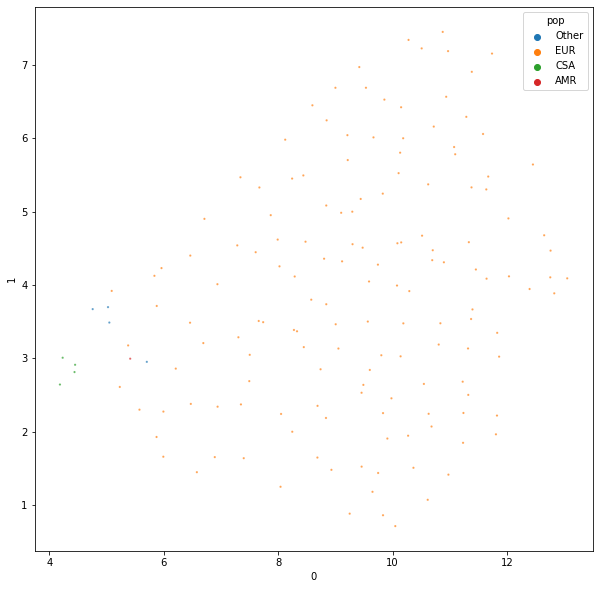

In [17]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ukb_predictions = hl.read_table("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls.ht")

ukb_predictions_pd = ukb_predictions.to_pandas()

data = pd.DataFrame(ukb_predictions_pd['pca_scores'].to_list())

proj_umap_pca = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.5, random_state=42).fit_transform(data)


umap = pd.DataFrame(proj_umap_pca)
umap['pop'] = ukb_predictions_pd['pop']

plt.figure(figsize=(10,10))
sns.color_palette("bright")
sns.scatterplot(data=umap, x=0, y=1, hue="pop", s=5, alpha = 0.7, marker ='o')
plt.show()

In [20]:
ukb_predictions_pd = ukb_predictions.to_pandas()

ukb_predictions_pd = ukb_predictions_pd[["s", "pop"]]
ukb_predictions_pd['pop'].value_counts()

EUR      150
Other      4
CSA        4
AMR        1
Name: pop, dtype: int64

## Identify related subjects

In [18]:
relatedness_ht = hl.pc_relate(qc_mt.GT, 0.01, k=10, min_kinship=0.05, block_size=512)

related_samples_to_remove = hl.maximal_independent_set(relatedness_ht.i, relatedness_ht.j, False)
print(related_samples_to_remove.count())

related_samples_to_remove.write("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/related_remove_cts.ht",overwrite=True)

2021-08-27 14:15:30 Hail: INFO: hwe_normalized_pca: running PCA using 146110 variants.
2021-08-27 14:15:30 Hail: INFO: pca: running PCA with 10 components...
2021-08-27 14:15:52 Hail: INFO: Wrote all 286 blocks of 146110 x 159 matrix with block size 512.
2021-08-27 14:15:55 Hail: INFO: wrote matrix with 11 rows and 146110 columns as 286 blocks of size 512 to /mnt/grid/janowitz/home/skleeman/tmp2/pcrelate-write-read-pB2XMUgY4QgjLvpmgCEizw.bm
2021-08-27 14:15:59 Hail: INFO: wrote matrix with 146110 rows and 159 columns as 286 blocks of size 512 to /mnt/grid/janowitz/home/skleeman/tmp2/pcrelate-write-read-VKjRXBtwbQbKoKbqskAivY.bm
2021-08-27 14:16:02 Hail: INFO: wrote matrix with 146110 rows and 159 columns as 286 blocks of size 512 to /mnt/grid/janowitz/home/skleeman/tmp2/pcrelate-write-read-IXJynrvS2lyT9I3eaUh9y2.bm
2021-08-27 14:16:05 Hail: INFO: wrote matrix with 159 rows and 159 columns as 1 block of size 512 to /mnt/grid/janowitz/home/skleeman/tmp2/pcrelate-write-read-MCqAPE88z7ecpJ

4


2021-08-27 14:16:26 Hail: INFO: wrote table with 4 rows in 1 partition to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/related_remove_cts.ht
    Total size: 116.00 B
    * Rows: 105.00 B
    * Globals: 11.00 B
    * Smallest partition: 4 rows (105.00 B)
    * Largest partition:  4 rows (105.00 B)


### Check final PCA

In [42]:
import pandas as pd
from hail.plot import show
from pprint import pprint
hl.plot.output_notebook()

qc_mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/qc_cts.mt')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/related_remove_cts.ht")
qc_mt = qc_mt.filter_cols(~hl.is_defined(related_samples_to_remove[qc_mt.col_key]))

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls2.ht")
qc_mt = qc_mt.annotate_cols(pop = panIO_predictions[qc_mt.s].pop)

mt_filter = qc_mt.filter_cols(qc_mt.pop=='EUR')
print(mt_filter.count(), flush=True)

eigenvalues, pcs, _ = hl.hwe_normalized_pca(mt_filter.GT, k=4)
                          
mt_filter = mt_filter.annotate_cols(scores = pcs[mt_filter.s].scores)
                          
p = hl.plot.scatter(mt_filter.scores[0],
                    mt_filter.scores[1],
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

Loading BokehJS ...

2021-08-27 17:28:11 Hail: INFO: Coerced sorted dataset


(146110, 145)


2021-08-27 17:28:12 Hail: INFO: Coerced sorted dataset
2021-08-27 17:28:12 Hail: INFO: hwe_normalized_pca: running PCA using 145953 variants.
2021-08-27 17:28:13 Hail: INFO: Coerced sorted dataset
2021-08-27 17:28:13 Hail: INFO: pca: running PCA with 4 components...
2021-08-27 17:28:35 Hail: INFO: Coerced sorted dataset


In [40]:
#Run PCA excluding relateds then project onto everyone
_, pcs, _ = hl.hwe_normalized_pca(mt_filter.GT, k=2)

    
scores_pca_ref = pcs
scores_pca_ref = scores_pca_ref.transmute(**{f'PC{i}': scores_pca_ref.scores[i - 1] for i in range(1, 3)})


scores_pca_ref = scores_pca_ref.annotate(PC1_Z = ((scores_pca_ref.PC1 - scores_pca_ref.aggregate(hl.agg.mean(scores_pca_ref.PC1))) / (scores_pca_ref.aggregate(hl.agg.stats(scores_pca_ref.PC1).stdev))),
                        PC2_Z = ((scores_pca_ref.PC2 - scores_pca_ref.aggregate(hl.agg.mean(scores_pca_ref.PC2))) / (scores_pca_ref.aggregate(hl.agg.stats(scores_pca_ref.PC2).stdev))))

p = hl.plot.scatter(scores_pca_ref.PC1_Z,
                    scores_pca_ref.PC2_Z,
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

scores_pca_ref = scores_pca_ref.filter((hl.abs(scores_pca_ref.PC1_Z) <6), keep=False)
print(scores_pca_ref.count())

panIO_predictions = panIO_predictions.annotate(pop = hl.case()
                                              .when(hl.is_defined(scores_pca_ref[panIO_predictions.s]), "Other")
                                              .default(panIO_predictions.pop))

panIO_predictions_pd = panIO_predictions.to_pandas()
panIO_predictions_pd = panIO_predictions_pd[["s", "pop"]]
panIO_predictions_pd['pop'].value_counts()
panIO_predictions.write("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls2.ht", overwrite=True)


2021-08-27 17:26:58 Hail: INFO: Coerced sorted dataset
2021-08-27 17:26:59 Hail: INFO: hwe_normalized_pca: running PCA using 145959 variants.
2021-08-27 17:26:59 Hail: INFO: Coerced sorted dataset
2021-08-27 17:27:00 Hail: INFO: pca: running PCA with 2 components...


2


2021-08-27 17:27:24 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 17:27:24 Hail: INFO: Ordering unsorted dataset with network shuffle
2021-08-27 17:27:25 Hail: INFO: wrote table with 159 rows in 8 partitions to /mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls2.ht
    Total size: 15.04 KiB
    * Rows: 15.03 KiB
    * Globals: 11.00 B
    * Smallest partition: 0 rows (21.00 B)
    * Largest partition:  159 rows (14.89 KiB)


## Generate cleaned dataset

In [44]:
#Import TCGA germline data post marker QC
mt = hl.read_matrix_table('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/raw_cts.mt')
mt_filter = hl.read_matrix_table('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/qc_cts.mt')

#Filter to autosomal SNPs with MAF >0.1%
mt = mt.filter_rows(mt.locus.in_autosome())
mt = hl.variant_qc(mt) #Default Hail variant QC pipeline
mt = mt.filter_rows(mt.variant_qc.AF[1] > 0.001) #MAF > 0.1%

#Add ancestry data
panIO_predictions = hl.read_table("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/ancestry_calls2.ht")
mt = mt.annotate_cols(pop = panIO_predictions[mt.s].pop)
mt_filter = mt_filter.annotate_cols(pop = panIO_predictions[mt_filter.s].pop)

#Filter to European population
mt = mt.filter_cols(mt.pop=='EUR')
mt_filter = mt_filter.filter_cols(mt_filter.pop=='EUR')

#Remove related samples
related_samples_to_remove = hl.read_table("/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/related_remove_cts.ht")
mt = mt.filter_cols(~hl.is_defined(related_samples_to_remove[mt.col_key]))
mt_filter = mt_filter.filter_cols(~hl.is_defined(related_samples_to_remove[mt_filter.col_key]))

print(mt.count())

#Generate principal components from high-quality SNPs with MAF >1% (selected above)
mt_filter = hl.variant_qc(mt_filter) 
mt_filter = mt_filter.filter_rows(mt_filter.variant_qc.AF[1] > 0.01) #MAF > 1% to speed up PCA
_, scores_pca_ref, _ = hl.hwe_normalized_pca(mt_filter.GT, k=4)

p = hl.plot.scatter(scores_pca_ref.scores[0],
                    scores_pca_ref.scores[1],
                    title='PCA', xlabel='PC1', ylabel='PC2')
show(p)

scores_pca_ref = scores_pca_ref.transmute(**{f'PC{i}': scores_pca_ref.scores[i - 1] for i in range(1, 5)})
scores_pd = scores_pca_ref.to_pandas()
scores_pd = scores_pd.rename(columns={'s': 'IID'})

scores_pd.to_csv('/mnt/grid/janowitz/rdata/trigger/imputation_gwas/hail/cts_pcs.tsv', sep="\t", index=False)

2021-08-27 17:29:43 Hail: INFO: Coerced sorted dataset


(11262658, 145)


2021-08-27 17:30:36 Hail: INFO: Coerced sorted dataset
2021-08-27 17:30:37 Hail: INFO: hwe_normalized_pca: running PCA using 145203 variants.
2021-08-27 17:30:38 Hail: INFO: Coerced sorted dataset
2021-08-27 17:30:39 Hail: INFO: pca: running PCA with 4 components...


2021-08-27 17:30:54 Hail: INFO: Ordering unsorted dataset with network shuffle


## Extract DIRC3 SNP

In [45]:
mt = mt.filter_rows(mt.locus == hl.locus("2", 218143731,reference_genome='GRCh37'))
mt.count()

variant2_entries = mt.entries().to_pandas()
variant2_entries['score_allele'] = [','.join(map(str, l)) for l in variant2_entries['GT.alleles']]
variant2_entries['score_allele'] = variant2_entries['score_allele'].map({'0,0': 0, '1,0': 1,
                                                                            '0,1':1, '1,1':2})
variant2_entries.to_csv('cts_dirc3_snp.csv', index=False)

2021-08-27 17:31:24 Hail: INFO: Coerced sorted dataset
2021-08-27 17:31:25 Hail: INFO: Coerced sorted dataset
